In [72]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
import numpy as np

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
print("Loading all libs...")

In [76]:
from google.colab import drive
drive.mount('/content/drive')

# Load Dataset

In [77]:
from load_data import *

def load_data():
    
    n_S = get_number_of_suppliers()
    n_U = get_number_of_users()
    
    Se, ST = load_supply()
    De, DT = load_demand()
    P = load_priority()
    A_prev, A_history = load_allocation()

    X = concat(Se, De, P, A_prev, A_history)  ## input
    
    y_demand = DT
    
    y_supply = ST
    
    return X, y_demand, y_supply

In [78]:
X, y_demand, y_supply = load_data()

# Split Train and Test

In [81]:
# split into train and test sets, 70% training data

from split_dataset import *

trainX, train_demand, train_supply, testX, test_demand, test_supply = split(X, y1, y2)

In [82]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Architecture

## Create the model for MTL

In [83]:
class Model(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X.shape, 20) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        
        self.supplyLSTM = nn.LSTM(20, y_supply.shape)
        self.demandLSTM = nn.LSTM(20, y_demand.shape)
        
    
    def forward(self, X):
        out = self.fc1(X)
        out = self.relu(out)
        out1 = self.fc2(out)
        embedding = self.fc3(out2) ## it is the learned embedding
        
        supply = self.supplyLSTM(embedding)
        demand = self.demandLSTM(embedding)
        
        return supply, demand

In [84]:
model = Model()

# MTL Training

In [85]:
log_var_a = torch.zeros((1,), requires_grad=True)
log_var_b = torch.zeros((1,), requires_grad=True)

In [86]:
params = ([p for p in model.parameters()] + [log_var_a] + [log_var_b])

In [87]:
optimizer = optim.Adam(params)

## loss criterion = mse

In [88]:
def criterion(y_pred, y_true, log_vars):
    loss = 0
    for i in range(len(y_pred)):
        precision = torch.exp(-log_vars[i])
        diff = (y_pred[i]-y_true[i])**2.
        loss += torch.sum(precision * diff + log_vars[i], -1)
    return torch.mean(loss)

In [89]:
num_epochs = 5

for i in range(num_epochs):

    epoch_loss = 0
    
    optimizer.zero_grad()

    out = model(trainX)

    loss = criterion(out, [train_supply, train_demand], [log_var_a, log_var_b])

    epoch_loss += loss.item()

    loss.backward()

    optimizer.step()

# Predict

In [90]:
pred_supply, pred_demand = model(testX)

# Plot 

## aggregated supply

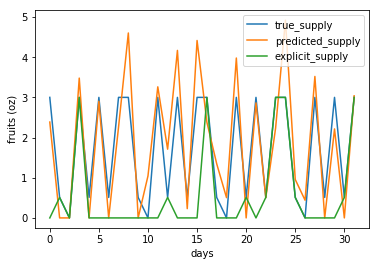

In [92]:
plt.plot(ST, label = 'true_supply')
plt.plot(pred_supply, label = 'predicted_supply')
plt.plot(Se, label = 'explicit_supply')
plt.xlabel("days")
plt.ylabel("fruits (oz)")
plt.legend()

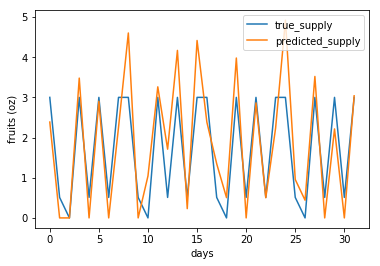

In [93]:
plt.plot(ST, label = 'true_supply')
plt.plot(pred_supply, label = 'predicted_supply')
plt.xlabel("days")
plt.ylabel("fruits (oz)")
plt.legend()

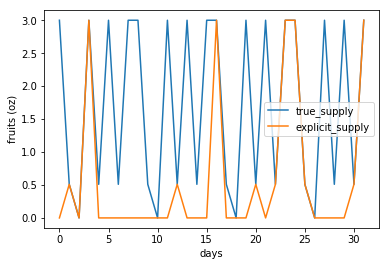

In [94]:
plt.plot(ST, label = 'true_supply')
plt.plot(Se, label = 'explicit_supply')
plt.xlabel("days")
plt.ylabel("fruits (oz)")
plt.legend()

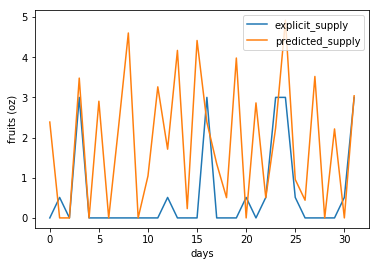

In [95]:
plt.plot(Se, label = 'explicit_supply')
plt.plot(pred_supply, label = 'predicted_supply')
plt.xlabel("days")
plt.ylabel("fruits (oz)")
plt.legend()

## demand (user/household 1)

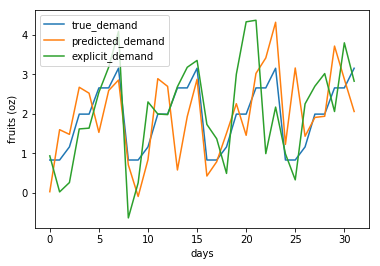

In [96]:
plt.plot(DT, label = 'true_demand')
plt.plot(pred_demand, label = 'predicted_demand')
plt.plot(De, label = 'explicit_demand')
plt.xlabel("days")
plt.ylabel("fruits (oz)")
plt.legend()

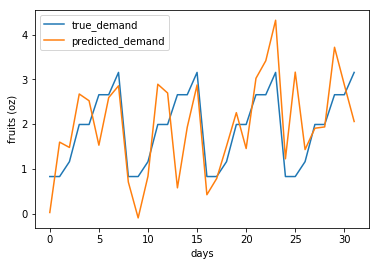

In [97]:

plt.plot(DT, label = 'true_demand')
plt.plot(pred_demand, label = 'predicted_demand')
plt.xlabel("days")
plt.ylabel("fruits (oz)")
plt.legend()

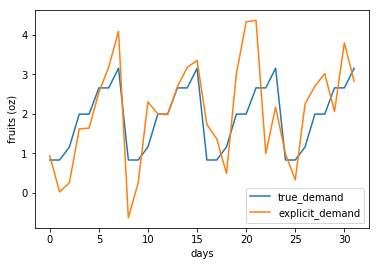

In [98]:
plt.plot(DT, label = 'true_demand')
plt.plot(De, label = 'explicit_demand')
plt.xlabel("days")
plt.ylabel("fruits (oz)")
plt.legend()

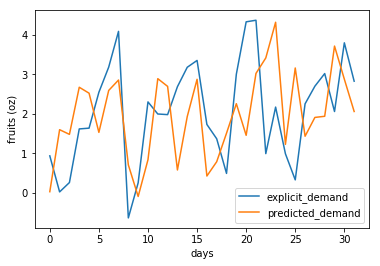

In [99]:
plt.plot(De, label = 'explicit_demand')
plt.plot(pred_demand, label = 'predicted_demand')
plt.xlabel("days")
plt.ylabel("fruits (oz)")
plt.legend()